In [131]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import random
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import xception
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [132]:
pd.options.display.max_rows = 100

In [133]:
#defining directory paths
image_dir = '/content/drive/MyDrive/Maestria 2 ciclo/Trabajo_imagenes/fotos_manometro'
labels_dir = '/content/drive/MyDrive/Maestria 2 ciclo/Trabajo_imagenes/label.csv'

In [134]:
labels = pd.read_csv(labels_dir)
labels.describe()

,presion,p
count,101.000000,101.000000
mean,1.742574,1.801980
std,0.559526,0.400495
min,0.000000,1.000000
25%,2.000000,2.000000
50%,2.000000,2.000000
75%,2.000000,2.000000
max,2.000000,2.000000


In [136]:
#distribution of classes in hour column
labels.presion.value_counts(normalize=True)

2    0.801980
1    0.138614
0    0.059406
Name: presion, dtype: float64

In [138]:
#distribution of classes in minute column
labels.p.value_counts(normalize=True)

2    0.80198
1    0.19802
Name: p, dtype: float64

ValueError: ignored

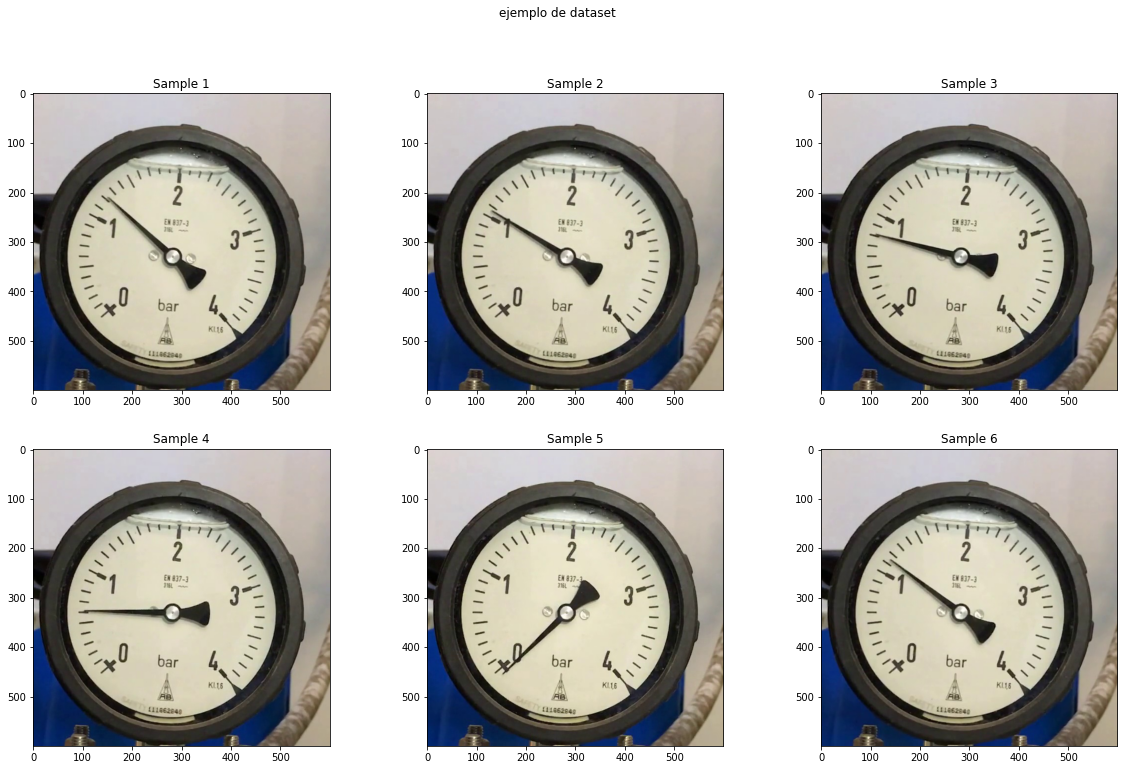

In [139]:
#preview of dataset
sample_dir = '/content/drive/MyDrive/Maestria 2 ciclo/Trabajo_imagenes/fotos_manometro'
fig = plt.figure(figsize=(20, 12))
plt.suptitle('ejemplo de dataset')
for i, file in enumerate(os.listdir(sample_dir)):
    img = image.load_img(os.path.join(sample_dir, file),
                         interpolation='box')
    img = image.img_to_array(img, dtype='float32')
    img /= 255.0
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title('Sample ' + str(i+1))

In [140]:
#transforming labels to multi-label binary format
labels_df = pd.read_csv(labels_dir)
labels_df['tuples'] = [tuple(x) for x in labels_df.values]
labels_df['tuples'] = [('presion' + str(x), 'val' + str(y)) for x,y in labels_df['tuples'].values]
labels_df = labels_df.drop(columns=['presion', 'p'])
# labels_df = labels_df.reset_index()
binarizer = MultiLabelBinarizer()
y = binarizer.fit_transform(labels_df['tuples'])

In [141]:
labels_df

,tuples
0,"(presion1, val1)"
1,"(presion1, val1)"
2,"(presion2, val2)"
3,"(presion2, val2)"
4,"(presion2, val2)"
...,...
96,"(presion0, val1)"
97,"(presion0, val1)"
98,"(presion0, val1)"
99,"(presion0, val1)"


In [142]:
#preview of dataframe
labels_df.head()

,tuples
0,"(presion1, val1)"
1,"(presion1, val1)"
2,"(presion2, val2)"
3,"(presion2, val2)"
4,"(presion2, val2)"


In [143]:
#distribution of unique labels
labels_df['tuples'].value_counts()

(presion2, val2)    81
(presion1, val1)    14
(presion0, val1)     6
Name: tuples, dtype: int64

In [144]:
#creating train-test split
train, test = train_test_split(labels_df, 
                               stratify=labels_df['tuples'],
                               test_size=0.20,
                               random_state=42
                              )

train_idx, test_idx = list(train.index), list(test.index)

In [145]:
train_test_split(labels_df, 
                               stratify=labels_df['tuples'],
                               test_size=0.20,
                               random_state=42
                              )

[               tuples
 63   (presion2, val2)
 19   (presion2, val2)
 2    (presion2, val2)
 20   (presion2, val2)
 46   (presion2, val2)
 90   (presion1, val1)
 45   (presion2, val2)
 25   (presion2, val2)
 15   (presion2, val2)
 39   (presion2, val2)
 56   (presion2, val2)
 75   (presion2, val2)
 14   (presion2, val2)
 22   (presion2, val2)
 71   (presion2, val2)
 43   (presion2, val2)
 76   (presion2, val2)
 0    (presion1, val1)
 13   (presion2, val2)
 83   (presion1, val1)
 96   (presion0, val1)
 89   (presion2, val2)
 58   (presion2, val2)
 41   (presion2, val2)
 74   (presion2, val2)
 10   (presion2, val2)
 53   (presion2, val2)
 69   (presion2, val2)
 50   (presion2, val2)
 8    (presion2, val2)
 78   (presion2, val2)
 80   (presion2, val2)
 65   (presion2, val2)
 97   (presion0, val1)
 68   (presion2, val2)
 6    (presion2, val2)
 91   (presion1, val1)
 34   (presion2, val2)
 30   (presion2, val2)
 12   (presion1, val1)
 85   (presion1, val1)
 5    (presion2, val2)
 81   (pres

In [146]:
random.shuffle(os.listdir(image_dir))

#Se tiene q modificar a partir de acá

In [147]:
def generate(image_directory, labels, train_idx=None, batch_size=64, size=(224, 224)):
    
    """
    Function to create generator of images and labels for the neural network. This allows for training
    the model with the limited memory available. The images and labels are generated in batches of a given size.
    The images are loaded, added to a batch, preprocessed and have their features extracted using a prebuilt model
    (in this case Xception Model). 
    
    Parameters
    ----------
    image_directory: str
        The path where the images are located
    labels: array-like or list
        list of labels in multi-label binary format
    batch_size: int, default=64
        the number of images per batch
    size: tuple, default=(224, 224)
        the height and width to which the image is resized. 
    
    Yields
    ------
    image_batch: array
        Array of image features of size=batch_size
    labels_batch: array
        Array of labels in multi-label binary format of size=batch_size
    
    """
    
   
    prebuilt_model = xception.Xception(include_top=True,                      
              weights='imagenet')                                            #loading prebuilt model
    
    xception_model = Model(inputs=prebuilt_model.input,        
                           outputs=prebuilt_model.layers[-2].output)         #repurposing prebuilt model for feature extraction
    
    
    
    while 1:
        
        if train_idx==None:
            image_filenames = os.listdir(image_directory)                    #obtaining list of image filenames
        else:
            image_filenames = [str(idx) + '.jpg' for idx in train_idx]
            
        random.shuffle(image_filenames)                                      #shuffling the list to add randomness every epoch

        
        image_batch = []                                                     #initializing empty image batch list
        labels_batch = []                                                    #initializing empty labels batch list
        
        for file in image_filenames:                                         #looping over all images in directory

            index = int(file.split('.')[0])                                  #extracting image number/index from filename
            
            img = image.load_img(os.path.join(image_directory, file),        #loading image
                                 target_size=size,
                                 interpolation='box')
            
            img_arr = image.img_to_array(img, dtype='float32')               #converting image to array
            
            label = labels[index]                                            #using image number/index to find correct label in dataframe
    
            image_batch.append(img_arr)                                      #appending the image to the batch
            labels_batch.append(label)                                       #appending the label to the batch

    
            if len(image_batch)==batch_size:                                 #check to see if batch has required size
                image_batch = np.array(image_batch)                          #converting image batch list to array
                image_batch = xception.preprocess_input(image_batch)         #using xception preprocessing on image batch array
                image_features = xception_model.predict(image_batch)         #using prebuilt xception model to extract features from batch
                image_batch = np.array(image_features)                       #converting features to array
                image_batch = image_batch.reshape(batch_size,                #reshaping feature array
                                                  image_features.shape[1])   
                labels_batch = np.array(labels_batch)                        #converting labels batch list to array
                yield image_batch, labels_batch                              #yielding image and labels batch array
                image_batch = []                                             #reinitializing the image batch
                labels_batch = []                                            #reinitializing the label batch
                gc.collect()                                                 #collecting garbage to free memory

In [148]:
#Defining training parameters
BATCH_SIZE = 256
IMAGE_SIZE = (299, 299) #this is the size suggested for Xception model
EPOCHS = 10
STEPS = int(len(train_idx) / BATCH_SIZE)

In [149]:
#testing generator
sample_generator = next(generate(image_directory=image_dir, 
                                 labels=y,
                                 train_idx=train_idx,
                                 batch_size=1, 
                                 size=IMAGE_SIZE))

FileNotFoundError: ignored